In [1]:
!nvidia-smi

Wed May 25 06:10:47 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   37C    P8     9W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
import torch #torch 자체
import torch.nn as nn  #torch에서 network 성분 가져올때
import torch.nn.functional as F 
from torchsummary import summary #network 분석 시 사용하는 package 많이 사용하진 않음

import torch.optim as optim
from torch.utils.data import DataLoader,random_split
from torch.utils.tensorboard import SummaryWriter
from torchvision import datasets, transforms  # dataset은 데이터셋 저장, transforms는 data augmentation기법에 사용
from torchvision import utils

import numpy as np
import matplotlib.pyplot as plt

 ### Step 1) 데이터 불러오기 및 전처리 

In [3]:
transform = transforms.Compose(
    [transforms.ToTensor(), 
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]
     )

In [4]:
train_dataset = datasets.CIFAR10(root="../data", train=True, download=True, transform=transform)
test_dataset = datasets.CIFAR10(root="../data", train=False, download=True, transform=transform)
split = 0.2
val=int(len(train_dataset)*split)
train = int(len(train_dataset)*(1-split))
train, valid = random_split(train_dataset,[train,val])
print(len(train),len(valid))

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting ../data/cifar-10-python.tar.gz to ../data
Files already downloaded and verified
40000 10000


In [5]:
writer = SummaryWriter()
train_loader = DataLoader(train,batch_size=64,num_workers=2)
valid_loader = DataLoader(valid,batch_size=64,num_workers=2) 
test_loader = DataLoader(test_dataset, batch_size=64)

image, label = next(iter(train_loader))
grid = utils.make_grid(image)
writer.add_image('images', grid, 0)

In [6]:
def imshow(img):
  img = (img/2 + 0.5)
  np_img = img.numpy()
  plt.imshow(np.transpose(np_img,(1,2,0)))

In [7]:
for i,data in  enumerate(train_loader):
  img,labels = data
  print(img.shape,labels.shape)
  break

torch.Size([64, 3, 32, 32]) torch.Size([64])


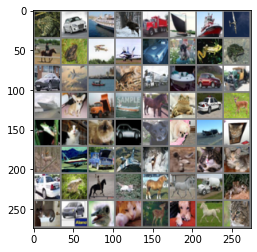

In [8]:
imshow(grid)

### Step 2) 네트워크 생성

- input_dim: 입력 데이터의 차원

- hidden_dim_list: 은닉 계층의 뉴런 수

- output_dim: 결과 데이터의 차원

In [9]:
class baseModel(nn.Module): 
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(3072,2048)
        self.fc2 = nn.Linear(2048,10)

    def forward(self,x):
      x = F.relu(self.fc1(x))
      x = self.fc2(x)
      return x

In [10]:
#nn의 module을 상속받아서 그 위에 layer를 쌓아올림
#linear안에는 input, output sizef를 입력할 수 있습니다.
class MyModel(nn.Module):  #네트워크 구성 성분 입력
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(3072,2048)
        self.fc2 = nn.Linear(2048,1024)
        self.fc3 = nn.Linear(1024,512)
        self.fc4 = nn.Linear(512,256)
        self.fc5 = nn.Linear(256,10)

    def forward(self,x):
      x = F.relu(self.fc1(x))
      x = F.relu(self.fc2(x))
      x = F.relu(self.fc3(x))
      x = F.relu(self.fc4(x))
      x = self.fc5(x)
      return x


class SequentialModel(nn.Module):
  def __init__(self):
    super().__init__()
    self.linear_relu_stack = nn.Sequential(
            nn.Linear(3072, 2048),
            nn.ReLU(),
            nn.Linear(2048, 1024),
            nn.ReLU(),
            nn.Linear(1024, 512),
            nn.ReLU(),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Linear(256, 10)
        )
  def forward(self,x):
    x =self.linear_relu_stack(x)
    return x


In [11]:
model = MyModel()

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model.to(device)


MyModel(
  (fc1): Linear(in_features=3072, out_features=2048, bias=True)
  (fc2): Linear(in_features=2048, out_features=1024, bias=True)
  (fc3): Linear(in_features=1024, out_features=512, bias=True)
  (fc4): Linear(in_features=512, out_features=256, bias=True)
  (fc5): Linear(in_features=256, out_features=10, bias=True)
)

In [12]:
model2 = SequentialModel()
model2.to(device)

SequentialModel(
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=3072, out_features=2048, bias=True)
    (1): ReLU()
    (2): Linear(in_features=2048, out_features=1024, bias=True)
    (3): ReLU()
    (4): Linear(in_features=1024, out_features=512, bias=True)
    (5): ReLU()
    (6): Linear(in_features=512, out_features=256, bias=True)
    (7): ReLU()
    (8): Linear(in_features=256, out_features=10, bias=True)
  )
)

In [13]:
summary(model, input_size=(3072,))
summary(model2,input_size=(3072,))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                 [-1, 2048]       6,293,504
            Linear-2                 [-1, 1024]       2,098,176
            Linear-3                  [-1, 512]         524,800
            Linear-4                  [-1, 256]         131,328
            Linear-5                   [-1, 10]           2,570
Total params: 9,050,378
Trainable params: 9,050,378
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.01
Forward/backward pass size (MB): 0.03
Params size (MB): 34.52
Estimated Total Size (MB): 34.57
----------------------------------------------------------------
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                 [-1, 2048]       6,293,504
              ReLU-2               

### Step 3) 손실 함수 (Loss) 및 업데이트 알고리즘 (Optimizer) 설정


In [14]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(params=model.parameters(), lr=0.001)
optimizer2 = optim.SGD(params=model2.parameters(), lr=0.001)

### Step 4) 학습 (Training)

 - CIFAR-10 데이터셋을 이용하여 다층퍼셉트론을 학습시켜봅시다.

 - 학습 과정은 다음과 같습니다.

    1. 입력 (x)에 대한 결과 **예측** -> y_pred

    2. y_pred와 정답 (y_true)을 비교하여 **손실함수의 값 계산** -> criterion(y_pred, y_true)

    3. 손실함수의 값이 작아지는 방향으로 네트워크 **업데이트** -> optimizer.step()

In [15]:
epochs = 20

for epoch in range(epochs):  
    running_loss = 0
    train_loss = 0

    for i, data in enumerate(train_loader):
        # Batch에 해당하는 Data 추출
        x, y_true = data #x는 input data에 해당 y_true는 label에
        x = x.reshape(-1, 32*32*3) #flatten
        x = x.to(device) 
        y_true = y_true.to(device) 

        optimizer.zero_grad()
        
        # 입력에 대한 결과 예측
        y_pred = model(x)

        # 예측값과 정답을 비교하여 손실함수의 값 계산
        loss = criterion(y_pred, y_true)
        # 손실함수의 값이 작아지는 방향으로 네트워크 업데이트
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
        running_loss += loss.item() #로깅용 running_loss
    train_loss /= len(train_loader)


    correct = 0
    total = 0
    val_loss = 0
    with torch.no_grad():
        for i, data in enumerate(valid_loader):
        #for i, (images,labels) in enumerate(valid_loader):
            images,labels=data
            images = images.reshape(-1, 32*32*3)
            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images)
            loss = criterion(outputs,labels)
            val_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            val_acc = 100 * correct / total
            writer.add_scalar("Acc/valid", val_acc, epoch)

    val_loss = val_loss / len(valid_loader)
    writer.add_scalars("Loss",{'train_loss':train_loss,'valid_loss':val_loss},epoch)
    print('Epoch {}, Train Loss: {}, Val Loss: {}, Val Acc: {}'.format(epoch, train_loss, val_loss, val_acc ))





Epoch 0, Train Loss: 2.3026332733154296, Val Loss: 2.3013442458620497, Val Acc: 10.15
Epoch 1, Train Loss: 2.300590986251831, Val Loss: 2.299245178319846, Val Acc: 10.75
Epoch 2, Train Loss: 2.29844732093811, Val Loss: 2.2969924310210406, Val Acc: 12.17
Epoch 3, Train Loss: 2.296105597305298, Val Loss: 2.2944743359924122, Val Acc: 13.69
Epoch 4, Train Loss: 2.293441284942627, Val Loss: 2.2915446758270264, Val Acc: 14.8
Epoch 5, Train Loss: 2.290298979187012, Val Loss: 2.288016138562731, Val Acc: 15.52
Epoch 6, Train Loss: 2.2864555713653565, Val Loss: 2.283595599945943, Val Acc: 16.74
Epoch 7, Train Loss: 2.2815555156707763, Val Loss: 2.2778287025014308, Val Acc: 18.21
Epoch 8, Train Loss: 2.2750758148193357, Val Loss: 2.270062893059603, Val Acc: 20.35
Epoch 9, Train Loss: 2.2662529029846192, Val Loss: 2.259332776828936, Val Acc: 22.63
Epoch 10, Train Loss: 2.253978377532959, Val Loss: 2.2442614364016586, Val Acc: 23.58
Epoch 11, Train Loss: 2.236864970779419, Val Loss: 2.2234353214312

In [ ]:
#Sequential Model
epochs = 10

for epoch in range(epochs):  
    running_loss = 0
    train_loss = 0

    for i, data in enumerate(train_loader):
        # Batch에 해당하는 Data 추출
        x, y_true = data #x는 input data에 해당 y_true는 label에
        x = x.reshape(-1, 32*32*3) #우리는 이걸 flatte해서 사용
        x = x.to(device) 
        y_true = y_true.to(device) 

        optimizer2.zero_grad()
        
        # 입력에 대한 결과 예측
        y_pred = model2(x)

        # 예측값과 정답을 비교하여 손실함수의 값 계산
        loss = criterion(y_pred, y_true)
        writer.add_scalar("Loss/train", loss, epoch)
        # 손실함수의 값이 작아지는 방향으로 네트워크 업데이트
        loss.backward()
        optimizer2.step()
        train_loss += loss.item()
        running_loss += loss.item() #로깅용 running_loss
    train_loss /= len(train_loader)
    correct = 0
    total = 0
    val_loss = 0
    with torch.no_grad():
        for i, data in enumerate(valid_loader):
        #for i, (images,labels) in enumerate(valid_loader):
            images,labels=data
            images = images.reshape(-1, 32*32*3)
            images = images.to(device)
            labels = labels.to(device)
            outputs = model2(images)
            loss = criterion(outputs,labels)
            writer.add_scalar("Loss/valid", loss, epoch)
            val_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            val_acc = 100 * correct / total
            writer.add_scalar("Acc/valid", val_acc, epoch)

    val_loss = val_loss / len(valid_loader)
    print('Epoch {}, Train Loss: {}, Val Loss: {}, Val Acc: {}'.format(epoch, train_loss, val_loss, val_acc ))

writer.close()

### Step 5) 성능평가 (Evaluation)

In [18]:
def evaluation(model):
  model.eval()
  correct = 0
  total = 0
  with torch.no_grad():
        for data in test_loader:
            images, labels = data
            images = images.reshape(-1, 3072)
            images = images.to(device)
            labels = labels.to(device)

            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        test_acc = 100 * correct / total
            
  return test_acc

In [19]:
print(evaluation(model))

26.42


In [ ]:
%load_ext tensorboard
%tensorboard --logdir=runs

In [ ]:
!kill 294